In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.constants import *
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import math
import sympy as sp
import scipy.sparse as sparse
import time
from numpy.linalg import LinAlgError

from scipy.optimize import curve_fit
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import auc

The following cell contains all the known parameters.

In [3]:
def initialize_integration_params(Vratio = 0.01, Rm = 1.e-5,Rc = 5.e-5,Diff = 1.e-4,
                                  ngrid = 25):
    """

    Initializes parameters to be used numerial scheme

    :param Vratio: Ratio of cell volume to external volume
    :param Rm: Radius of compartment (cm)
    :param Diff: Diffusion coefficient
    :param Rc: Effective Radius of cell (cm)
    :param ngrid: number of spatial grid points
    :return integration_params: dictionary of integration constants
    """


    # Integration Parameters
    integration_params = dict()
    integration_params['Vratio'] = Vratio
    integration_params['Rm'] = Rm
    integration_params['Diff'] = Diff
    integration_params['Rc'] = Rc
    integration_params['ngrid'] = ngrid
    integration_params['m_m'] = (Rm**3)/3
    integration_params['m_c'] = (Rc**3)/3
    integration_params['nVars'] = 5*(2+int(ngrid)) + 2


    return integration_params

I set the non-dimensional parameters below.

In [4]:
def initialize_dim_scaling(**kwargs):
    """
    Computes non-dimensional scalings for each state variable
    :param kwargs:
    kwargs[VfDhaB]: V_f for G <-> H
    kwargs[KmDhaBG]: Km for G in G <-> H
    kwargs[KmDhaBH]: Km for H in G <-> H

    kwargs[VfIcdE]: V_f for D + I <-> N + A
    kwargs[KmIcdED]: K_m for D in D + I <-> N + A
    kwargs[KmIcdEI]: K_m for I in D + I <-> N + A
    kwargs[KiIcdEN]: K_m for N in D + I <-> N + A
    kwargs[KiIcdEA]: K_m for A in D + I <-> N + A

    :return dimscalings: list of dimensional scalings
    """
    #scalings
    dimscalings = dict()
    dimscalings['N0'] = kwargs['KmDhaTN']
    dimscalings['D0'] = kwargs['KmIcdED']
    dimscalings['G0'] = kwargs['KmDhaBG']
    dimscalings['H0'] = kwargs['KmDhaTH']
    dimscalings['P0'] = kwargs['KiDhaTP']
    dimscalings['A0'] = kwargs['KiIcdEA']
    dimscalings['I0'] = kwargs['KmIcdEI']

    return dimscalings

In [5]:
def initialize_dimless_param(**kwargs):
    """
    Computes non-dimensional parameters
    :param kwargs:
    kwargs[VfDhaB]: V_f for G <-> H
    kwargs[KmDhaBG]: Km for G in G <-> H
    kwargs[KmDhaBH]: Km for H in G <-> H

    kwargs[VfIcdE]: V_f for D + I <-> N + A
    kwargs[KmIcdED]: K_m for D in D + I <-> N + A
    kwargs[KmIcdEI]: K_m for I in D + I <-> N + A
    kwargs[KiIcdEN]: K_m for N in D + I <-> N + A
    kwargs[KiIcdEA]: K_m for A in D + I <-> N + A

    :return param_list: list of non-dimensional parameters
    """

    param_name = ['VfDhaB', 'VfDhaT', 'VfIcdE', 'KmDhaBG', 'KiDhaBH',
                  'KmDhaTH', 'KmDhaTN', 'KiDhaTP','KiDhaTD', 'KmIcdED',
                  'KmIcdEI', 'KiIcdEA', 'KiIcdEN', 'km', 'kc','GInit','IInit',
                  'NInit','DInit','Rm','Diff']


    for key in kwargs.keys():
        assert key in param_name

    # constants
    T = 298 # room temperature in kelvin
    R =  8.314 # gas constant
    DeltaGDhaT = -35.1 / (R * T)  # using Ph 7.8 since the IcdE reaction is forward processing
    DeltaGDhaB = -18.0 / (R * T)  # using Ph 7.8 since the IcdE reaction is forward processing
    DeltaGIcdE = -11.4 / (R * T)  # using Ph 7.8 since the IcdE reaction is forward processing

    # time scale
    t0 =  kwargs['Rm'] /(3*kwargs['km'] * kwargs['Diff'])


    # non-dimensional parameters

    param_dict = dict()

    param_dict['alpha0'] = t0*kwargs['VfDhaB']/kwargs['KmDhaBG']
    param_dict['alpha1'] = t0*kwargs['VfDhaB']/kwargs['KmDhaTH']
    param_dict['alpha2'] = t0*kwargs['VfDhaT']/kwargs['KmDhaTH']
    param_dict['alpha3'] = t0*kwargs['VfDhaT']/kwargs['KmDhaTN']
    param_dict['alpha4'] = t0*kwargs['VfIcdE']/kwargs['KmDhaTN']
    param_dict['alpha5'] = t0*kwargs['VfDhaT']/kwargs['KiDhaTP']
    param_dict['alpha6'] = t0*kwargs['VfDhaT']/kwargs['KmIcdED']
    param_dict['alpha7'] = t0*kwargs['VfIcdE']/kwargs['KmIcdED']
    param_dict['alpha8'] = t0*kwargs['VfIcdE']/kwargs['KmIcdEI']
    param_dict['alpha9'] = t0*kwargs['VfIcdE']/kwargs['KiIcdEA']

    param_dict['beta0'] = kwargs['KmDhaTH']/kwargs['KiDhaBH']
    param_dict['beta1'] = kwargs['KmIcdED']/kwargs['KiDhaTD']
    param_dict['beta2'] = kwargs['KmDhaTN']/kwargs['KiIcdEN']

    param_dict['gamma0'] = (kwargs['KmDhaTH']/kwargs['KmDhaBG'])*np.exp(DeltaGDhaB)
    param_dict['gamma1'] = (kwargs['KiDhaTP']*kwargs['KmIcdED']/(kwargs['KmDhaTH']*kwargs['KmDhaTN']))*np.exp(DeltaGDhaT)
    param_dict['gamma2'] = (kwargs['KiIcdEA']*kwargs['KmDhaTN']/(kwargs['KmIcdED']*kwargs['KmIcdEI']))*np.exp(DeltaGIcdE)

    param_dict['km'] = kwargs['km']
    param_dict['kc'] = kwargs['kc']
    param_dict['t0'] = t0

    return param_dict

Below computes the spatial derivative.

In [6]:
def SDeriv(*args):
    """
    Computes the spatial derivative of the system at time point, t
    :param t: time
    :param x: state variables
    :param diffeq_params: differential equation parameters
    :param param_vals: integration parameters
    :return: d: a list of values of the spatial derivative at time point, t
    """

    ###################################################################################
    ################################# Initialization ##################################
    ###################################################################################
    t = args[0]
    x = args[1]
    integration_params = args[2]
    param_vals =  args[3]

    # Integration Parameters
    n_compounds_cell = 5
    # differential equation parameters
    param_vals = param_vals.copy()
    param_vals['Rm'] = integration_params['Rm']
    param_vals['Diff'] = integration_params['Diff']
    param_dict = initialize_dimless_param(**param_vals)

    # coefficients for the diffusion equation

    pdecoef = param_dict['t0']*integration_params['Diff']*((3.**4.)**(1/3))/((integration_params['m_m']**2.)**(1./3.))
    bc1coef = ((3.**2.)**(1/3))/(integration_params['m_m']**(1./3.))
    bc2coef = (((3.*integration_params['m_c'])**2)**(1./3.))/integration_params['m_m']
    ode2coef = param_dict['t0']*integration_params['Diff']*integration_params['Vratio']*3.*param_dict['kc']/integration_params['Rc']

    # rescaling
    M_cell = (integration_params['Rc'] / integration_params['Rm']) ** 3
    M_mcp = 1.
    DeltaM = np.divide((M_cell - M_mcp), (integration_params['ngrid']-1))

    assert len(x) == 5 * (2 + (integration_params['ngrid'])) + 2
    d = np.zeros((len(x))).tolist()  # convert to list to allow use of symbolic derivatives

    ###################################################################################
    ################################## MCP reactions ##################################
    ###################################################################################

    R_DhaB = (x[2] - param_dict['gamma0'] * x[3]) / (1 + x[2] + x[3] * param_dict['beta0'])
    R_DhaT = (x[3] * x[0] - param_dict['gamma1'] * x[4] * x[1]) / (1 + x[3] * x[0] + param_dict['beta1'] * x[4] * x[1])
    R_IcdE = (x[1] * x[6] - param_dict['gamma2'] * x[5] * x[0]) / (1 + x[6] * x[1] + param_dict['beta2'] * x[5] * x[0])

    d[0] = -param_dict['alpha3'] * R_DhaT + param_dict['alpha4'] * R_IcdE  # microcompartment equation for N
    d[1] = param_dict['alpha6'] * R_DhaT - param_dict['alpha7'] * R_IcdE  # microcompartment equation for D

    d[2] = -param_dict['alpha0'] * R_DhaB + x[2 + n_compounds_cell] - x[2]  # microcompartment equation for G
    d[3] = param_dict['alpha1'] * R_DhaB - param_dict['alpha2'] * R_DhaT + x[3 + n_compounds_cell] - x[3]  # microcompartment equation for H
    d[4] = param_dict['alpha5'] * R_DhaT + x[4 + n_compounds_cell] - x[4]  # microcompartment equation for P
    d[5] = param_dict['alpha9'] * R_IcdE + x[5 + n_compounds_cell] - x[5]  # microcompartment equation for A
    d[6] = - param_dict['alpha8'] * R_IcdE + x[6 + n_compounds_cell] - x[6]  # microcompartment equation for I



    ####################################################################################
    ##################################### boundary of MCP ##############################
    ####################################################################################

    M = M_mcp

    first_coef = pdecoef * (((M + 0.5 * DeltaM) ** 4.) ** (1. / 3.)) / (DeltaM ** 2)
    second_coef = pdecoef * param_dict['km'] * (((M - 0.5 * DeltaM) ** 4.) ** (1. / 3.)) / (bc1coef * DeltaM)

    for i in range(7, 12):
        # BC at MCP for the ith compound in the cell
        d[i] = first_coef * (x[i + n_compounds_cell] - x[i]) - second_coef * (x[i] - x[i - n_compounds_cell])

    ####################################################################################
    ##################################### interior of cell #############################
    ####################################################################################

    for k in range(2, (integration_params['ngrid'])):
        start_ind = 7 + (k - 1) * n_compounds_cell
        end_ind = 7 + k * n_compounds_cell
        M += DeltaM  # update M
        # cell equations for ith compound in the cell
        d[start_ind:end_ind] = (pdecoef/(DeltaM**2)) * ((((M + 0.5 * DeltaM) ** 4.) ** (1. / 3.)) * (x[(start_ind + n_compounds_cell):(end_ind + n_compounds_cell)] - x[start_ind:end_ind])
                                          - (((M - 0.5 * DeltaM) ** 4.) ** (1. / 3.)) * (x[start_ind:end_ind] -x[(start_ind - n_compounds_cell):(end_ind- n_compounds_cell)]))


    ####################################################################################
    ###################### boundary of cell with external volume #######################
    ####################################################################################

    M = M_cell

    first_coef = pdecoef * param_dict['kc'] * (((M + 0.5 * DeltaM) ** 4) ** (1 / 3.))/ (bc2coef * DeltaM)
    second_coef = pdecoef * (((M - 0.5 * DeltaM) ** 4) ** (1 / 3.))/(DeltaM**2)

    for i in reversed(range(-6, -11, -1)):
        # BC at ext volume for the ith compound in the cell
        d[i] = first_coef * (x[i + n_compounds_cell] - x[i]) - second_coef * (x[i] - x[i - n_compounds_cell])

    #####################################################################################
    ######################### external volume equations #################################
    #####################################################################################

    for i in reversed(range(-1, -6, -1)):
        d[i] = ode2coef * (x[i - n_compounds_cell] - x[i])  # external equation for concentration
    return d

In [7]:
params = {'KmDhaTH': 1.,
          'KmDhaTN': 1.,
          'KiDhaTD': 1.,
          'KiDhaTP': 1.,
          'VfDhaT': 1.,
          'VfDhaB': 1.,
          'KmDhaBG': 1.,
          'KiDhaBH': 1.,
          'VfIcdE': 1.,
          'KmIcdED': 1.,
          'KmIcdEI': 1.,
          'KiIcdEN': 1.,
          'KiIcdEA': 1.,
          'km': 1.,
          'kc': 1.,
          'GInit': 1,
          'IInit': 1,
          'NInit': 1,
          'DInit': 1}

In [8]:
ngrid=25
integration_params = initialize_integration_params(ngrid=ngrid)
SDerivParameterized = lambda t,x: SDeriv(t,x,integration_params,params)
nVars = integration_params['nVars']
x_list_sp = np.array(sp.symbols('x:' + str(nVars)))

#jacobian
SDerivSymbolic = SDerivParameterized(0,x_list_sp)
SDerivGrad = sp.Matrix(SDerivSymbolic).jacobian(x_list_sp)
SDerivGradFun = sp.lambdify(x_list_sp, SDerivGrad, 'numpy')
SDerivGradFunSparse = lambda t,x: sparse.csr_matrix(SDerivGradFun(*x))

In [9]:
# initial conditions
dimscalings = initialize_dim_scaling(**params)
n_compounds_cell = 5
y0 = np.zeros((integration_params['ngrid'] + 2) * n_compounds_cell + 2)
y0[-5] = params['GInit']/ dimscalings['G0']  # y0[-5] gives the initial state of the external substrate.
y0[-1] = params['IInit'] / dimscalings['I0']  # y0[-1] gives the initial state of the external substrate.
y0[0] = params['NInit'] / dimscalings['N0']  # y0[5] gives the initial state of the external substrate.
y0[1] = params['DInit'] / dimscalings['D0']  # y0[6] gives the initial state of the external substrate.

In [10]:
# time samples
fintime = 1e7
start_time = time.time()
sol = solve_ivp(SDerivParameterized,[0, fintime], y0, method="BDF",jac=SDerivGradFunSparse,
                atol=1.0e-5,rtol=1.0e-5)
end_time = time.time()
print(str(end_time-start_time))

0.21819710731506348


In [11]:
sol.message

'The solver successfully reached the end of the integration interval.'

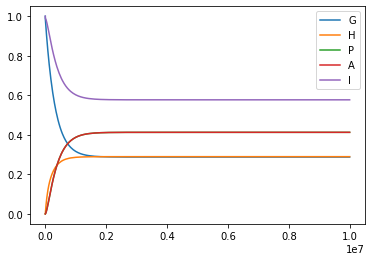

In [12]:
%matplotlib inline
plt.plot(sol.t,sol.y[-5:,:].T)
plt.legend(['G','H','P','A','I'],loc='upper right')
plt.show()

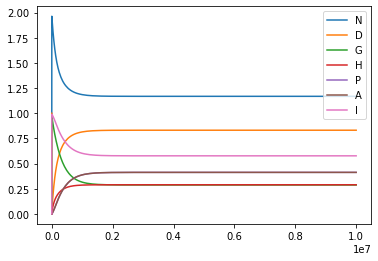

In [13]:
%matplotlib inline
plt.plot(sol.t,sol.y[:7,:].T)
plt.legend(['N','D','G','H','P','A','I'],loc='upper right')
plt.show()

## Stiff Solver

In [14]:
import sympy as sp
import scipy.sparse as sparse
import time
from numpy.linalg import LinAlgError

In [15]:
def newton(f, x0, fprime, full_output=True, conv_tol =1e-5, root_tol = 1e-5, max_iters=5,output_level=0):
    # initialize parameters
    converged = False
    xn = x0
    iters = 0 
    status = -99
    
    

    #initialize function
    fn = f(xn)
    norm_f = np.max(np.absolute(fn))
    diff_x = np.max(np.absolute(xn - x0))
    gradn = fprime(xn)
    
    #print statement
    if output_level >= 2:
        output_header = '%6s %9s %9s' % ('iter', '||f||_1', '||x_n-x_0||_1')
        print(output_header)
        print('%6i %9.2e %9.2e' % (iters, norm_f, diff_x))
        
    while 1:
        ###########################################
        ########### Convergence Checks ############
        ###########################################
        if iters > 0 and diff_x < root_tol:
            status = 1
            converged = True
            break

        if norm_f < conv_tol:
            status = 0
            converged = True
            break

        if iters >= max_iters:
            status = -1
            break
            
        ###########################################
        ############## Newton step ################
        ###########################################
        
        try:
            delta = sparse.linalg.spsolve(gradn,fn)
            xn = xn - delta
            iters += 1
        except LinAlgError:
            status = -2
            break
            
        #update difference in x
        diff_x = np.max(np.absolute(xn - x0))
        #update function
        fn = f(xn)
        norm_f = np.max(np.absolute(fn))
        
        # print statement
        if output_level >= 2 and iters % 100 == 0:
            output_header = '%6s %9s %9s' % ('iter', '||f||_1', '||x_n-x_0||_1')
            print(output_header)
            
        if output_level >= 2 and iters % 10 ==0:
            print('%6i %9.2e %9.2e' % (iters, norm_f, diff_x))
    
    if output_level >= 1:
        print('')
        print('||f||_1 at final point...............: %g' % norm_f)
        print('||x_n-x_0||_1 at final point.........: %g' % diff_x)
        print('Number of iterations.................: %d' % iters)
        print('')

        if status == 1:
            print('Exit: Critical point found since ||x_n-x0||_1 is less than tolerance.')
        elif status == 0:
            print('Exit: Critical point found since ||f(x_n)||_1 is less than tolerance.')
        elif status == -1:
            print('Exit: Maximum number of iterations (%d) exceeded.' %
                  iters)
        elif status == -2:
            print('Exit: Singular jacobian matrix.')
        else:
            print('ERROR: Unknown status value: %d\n' % status)

    if full_output==True:
        return [converged, xn]
    else:
        return xn

In [19]:
class BDF:
    def __init__(self,rhs, y0, tspan, devrhs = None, order = 2, dt = 1e-2, max_dt = 1.0, min_dt = 1e-7, dt_cut = 2, 
                 dt_raise=2, abstol=1e-6,reltol=1e-6, devtol = 1e-30, maxtime = 5.*60.):
        '''
        Initialization of multistep BDF scheme object
        Args:
            rhs: right hand side of the differential equation
            y0 : initial conditions 
            tspan: time interval of integration. A list of two vectors.
            devrhs: derivative of the rhs wrt to state vectors
            dt: initial time step
            max_dt: maximum time step
            min_dt: minimum time step
            dt_cut: factor to reduce time step. If non-adaptive set, dt_cut = 1.0
            dt_raise: factor to increase time step. If non-adaptive set, dt_raise = 1.0
            abstol: absolute error tolerance
            reltol: relative error tolerance
            devtol: tolerance of the derivative to be 0
            maxtime: maximum time to run the program
        '''
        self.rhs = rhs
        self.y0 = y0
        self.t0 = tspan[0]
        self.devrhs = devrhs
        self.order = order
        self.tspan = tspan
        self.dt = dt
        self.max_dt = max_dt
        self.min_dt = min_dt
        self.dt_cut = dt_cut
        self.dt_raise = dt_raise
        self.abstol = abstol
        self.reltol = reltol
        self.devtol = devtol
        self.maxtime = maxtime
        
        
    def step(self,t,*argv):
        '''
        Multistep backwards differentiation
        
        Args: 
            t: current time of the time interval
            argv[0]: current state vector, y_n
            argv[1]: previous state vector, y_n-1
            argv[2]: 2nd previous state vector, y_n-2
        '''
        yvals = {}
        for i,arg in enumerate(argv): 
            if i == 0:
                yvals["y_"+str(i)] = arg
            else:
                yvals["y_-"+str(i)] = arg

        if len(argv) == 1:
            #BDF-1 
            numeric_scheme = lambda y_next: y_next - yvals["y_0"] - self.dt*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)
        elif len(argv) == 2:
            #BDF-2
            numeric_scheme = lambda y_next: y_next - (4./3.)*yvals["y_0"] + (1./3.)*yvals["y_-1"] - self.dt*(2./3.)*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*(2./3.)*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)
        elif len(argv) == 3:
            #BDF-3
            numeric_scheme = lambda y_next: y_next - (18./11.)*yvals["y_0"] + (9./11.)*yvals["y_-1"] - (2./11.)*yvals["y_-2"] - self.dt*(6./11.)*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*(6./11.)*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)
        elif len(argv) == 4:
            #BDF-4 -- this is unstable
            numeric_scheme = lambda y_next: y_next - 4.*(12./25.)*yvals["y_0"] + 3.*(12./25.)*yvals["y_-1"] - (4./3.)*(12./25.)*yvals["y_-2"] + (1./4.)*(12./25.)*yvals["y_-3"] - self.dt*(12./25.)*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*(12./25.)*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)
        elif len(argv) == 5:
            #BDF-5 -- this is unstable
            numeric_scheme = lambda y_next: y_next - 5.*(60./137.)*yvals["y_0"] + 5.*(60./137.)*yvals["y_-1"] - (10./3.)*(60./137.)*yvals["y_-2"] + (5./4.)*(60./137.)*yvals["y_-3"] - (1./5.)*(60./137.)*yvals["y_-4"] - self.dt*(60./137.)*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*(60./137.)*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)

        return [iter_sol[0], iter_sol[1]]
    
    
    def initialize(self,h=1e-12):
        '''
        Generate order-1 entries for a multistep BDF scheme using RK4
        Args:
            order: order of the BDF scheme
            h: stepsize for RK4. Note -- take h small so as to not affect the 
               order and error of the BDF scheme to be ran
        
        '''
        order = self.order 
        while(len(self.t) < order):
            y = self.y[-1]
            t = self.t[-1]
            
            # take a step Rk4 step 
            
            k1 = self.rhs(t,y)
            k2 = self.rhs(t + h/2., y + k1*h/2.)
            k3 = self.rhs(t + h/2., y + k2*h/2.)
            k4 = self.rhs(t + h, y + k3*h)
            
            ynew = y + (k1 + 2.*k2 + 2.*k3 + k4)*h/6.
            tnew = t + h
            
            # store step
            
            (self.y).append(ynew)
            (self.t).append(tnew)
            
            
            
    def integrate(self,initalize_h =1e-100):
        
        self.y = [self.y0]
        self.t = [self.t0]
        
        # parameters for integration
        order = self.order
        dt = self.dt
        min_dt = self.min_dt
        max_dt = self.max_dt
        dt_cut = self.dt_cut
        dt_raise = self.dt_raise
        tspan = self.tspan
        devtol = self.devtol
        maxtime = self.maxtime
        reltol = self.reltol
        abstol = self.abstol
        
        status = -99
        
        output_header = '{}' .format('    t     \t     dt     \t ||slope||_1 \t time')
        print(output_header)
        print('%3.4e \t %3.4e  \t %3.4e \t %9.4e' % (self.t[-1], self.dt, 0.0, 0.0))
        # initialize with RK45
        if order > 1:
            self.initialize(initalize_h)
            
        ##################################
        ########### Begin Loop ###########
        ##################################
        
        # start time
        start_time = time.time()
        
        
        while 1:

            # compute time of loop
            current_time = time.time()
            total_time = current_time - start_time
            maxgrad = np.max(np.absolute(self.rhs(self.t[-1],self.y[-1])))
            # reset dt
            if dt > max_dt:
                dt = max_dt
                self.dt = dt
            
            # potential new time
            tnew = self.t[-1] + dt
            
            if tnew > tspan[-1]:
                dt = tspan[-1] - self.t[-1]
                self.dt = dt
                tnew = self.t[-1] + dt
            #########################################
            ############ Break Conditions ###########
            #########################################
            
            
            if not (self.t[-1] < tspan[-1]):
                # end of interval
                status = 0
                break
                
            if dt < min_dt:
                #step size too small
                status = -1
                break
                
            if maxgrad < devtol:
                # 1-norm of derivative too small
                status = -2
                break 
            
            if total_time > maxtime:
                # time of the program exceeded
                status = -3
                break
            
            ##########################################
            ############## Take Time Step ############
            ##########################################
            

            # take a step
            yns = self.y[-order:] # get the last "order" vectors
            yns = yns[::-1] # reverse the order of the vectors
            iter_converged,ynew = self.step(self.t[-1],*yns)
        
            if len(self.t) % 100 == 0:
                print(output_header)
            
            if len(self.t) % 10 == 0:
                print('%3.4e \t %3.4e  \t %3.4e \t %9.4e' % (self.t[-1], self.dt, maxgrad, total_time))
                
            ###########################################
            ###### Error and Convergence Checks #######
            ###########################################
            
            abs_error = np.absolute(ynew  - self.y[-1])
            

            #check convergence, error
            if (not iter_converged) | np.any(ynew < 0) | np.any(abs_error > abstol):
               dt /= dt_cut
               self.dt = dt
            else:
               dt *= dt_raise
               self.dt = dt
               (self.t).append(tnew)
               (self.y).append(ynew)
            #(self.t).append(tnew)  
            #(self.y).append(ynew)
            ###########################################
            ############ Print Statements #############
            ###########################################
            

            
        ##################################
        ############ End Loop ############
        ##################################

        ##################################
        ######## Finalize results ########
        ##################################
        
        print(output_header)
        print('%3.4e \t %3.4e  \t %3.4e \t %9.4e' % (self.t[-1], self.dt, maxgrad, total_time))

        print('')
        print('Status ..................................................: %d' % status)
        print('Final time...............................................: %g' % self.t[-1])
        print('Time of loop.............................................: %g' % total_time)
        print('Maximum slope............................................: %g' % maxgrad)
        print('')

        if status == 0:
            print('Exit: Intergration Success.')
        elif status == -1:
            print('Exit: Step size, ' + '{:.2E}'.format(dt) + ', is smaller than smallest allowed step-size.')
        elif status == -2:
            print('Exit: Steady state reached.')
        elif status == -3:
            print('Exit: Integration is taking too long, %3.4e seconds.' % total_time)
        else:
            print('ERROR: Unknown status value: %d\n' % status)
        return [status,np.array(self.t),np.array(self.y)]
    
    

In [20]:
x_list_sp = np.array(sp.symbols('x:' + str( 5*(2+(ngrid)) + 2)))
SDerivSymbolic = SDeriv(0,x_list_sp,integration_params,params)
SDerivGrad = sp.Matrix(SDerivSymbolic).jacobian(x_list_sp)
SDerivGradFun = sp.lambdify(x_list_sp, SDerivGrad, 'numpy')
SDerivGradFunSparse = lambda t,x: sparse.csr_matrix(SDerivGradFun(*x))
SDerivParameterized = lambda t,x: np.array(SDeriv(t,x,integration_params,params))

In [21]:
start_time= time.time()
bdf=BDF(SDerivParameterized, y0, [0,1e7], devrhs = SDerivGradFunSparse, dt = 1,
        min_dt=1e-30, max_dt = 5e6,abstol=.1,order=3)
[status,t,y] = bdf.integrate()
end_time= time.time()
print('time: ' + str(end_time-start_time))
status

    t     	     dt     	 ||slope||_1 	 time
0.0000e+00 	 1.0000e+00  	 0.0000e+00 	 0.0000e+00
4.7500e+00 	 2.0000e+00  	 9.9193e-02 	 7.0282e-02
4.7500e+00 	 1.0000e+00  	 9.9193e-02 	 7.5015e-02
5.4750e+01 	 1.6000e+01  	 8.7100e-03 	 1.5509e-01
8.2468e+03 	 8.1920e+03  	 4.2221e-06 	 2.2437e-01
1.8028e+05 	 3.2768e+04  	 1.5256e-06 	 3.4715e-01
1.8028e+05 	 1.6384e+04  	 1.5256e-06 	 3.5361e-01
3.9327e+05 	 3.2768e+04  	 6.6606e-07 	 4.7998e-01
6.5541e+05 	 3.2768e+04  	 2.8831e-07 	 6.0464e-01
6.5541e+05 	 1.6384e+04  	 2.8831e-07 	 6.1118e-01
8.5202e+05 	 6.5536e+04  	 1.5687e-07 	 7.1739e-01
8.5202e+05 	 3.2768e+04  	 1.5687e-07 	 7.2577e-01
8.5202e+05 	 1.6384e+04  	 1.5687e-07 	 7.3441e-01
1.0650e+06 	 6.5536e+04  	 7.9253e-08 	 8.3706e-01
1.0650e+06 	 3.2768e+04  	 7.9253e-08 	 8.4372e-01
1.3272e+06 	 3.2768e+04  	 3.2944e-08 	 9.6742e-01
    t     	     dt     	 ||slope||_1 	 time
1.5893e+06 	 3.2768e+04  	 1.4499e-08 	 1.0920e+00
1.8351e+06 	 3.2768e+04  	 6.8524e-09 	 1.217

0

In [22]:
scalings = list(dimscalings.values())
volcell = 4 * np.pi * (integration_params['Rc'] ** 3) / 3
volmcp = 4 * np.pi * (integration_params['Rm'] ** 3) / 3
volratio = integration_params['Vratio']
# create grid
M_cell = (integration_params['Rc'] / integration_params['Rm']) ** 3  # why?
M_mcp = 1.
Mgrid = np.linspace(M_mcp, M_cell, integration_params['ngrid'] - 1)
DeltaM = np.divide((M_cell - M_mcp), (integration_params['ngrid'] - 1))

In [23]:
numeachcompound = 2 + integration_params['ngrid']
ncompounds = 5
sol.y[:2, :] = (np.multiply(sol.y[:2, :].T, scalings[:2])).T
for i in range(numeachcompound):
    j = range(2 + i * ncompounds, 2 + (i + 1) * ncompounds)
    sol.y[j, :] = (np.multiply(sol.y[j, :].T, scalings[2:])).T

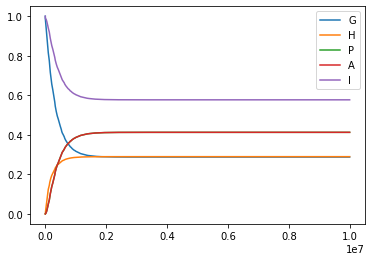

In [24]:
%matplotlib inline
plt.plot(bdf.t,np.array(bdf.y)[:,-5:])
plt.legend(['G','H','P','A','I'],loc='upper right')
#filename = "VfDhaB_"+str(VfDhaB)+"_KmDhaBG_" + str(KmDhaBG) + "_KiDhaBH_" + str(KiDhaBH) + "_VfIcdE_"  + str(VfIcdE) + "_KmIcdEA_" + str(KmIcdEA) + "_KmIcdEN_" + str(KmIcdEN) + "_KiIcdED_" + str(KiIcdED) + "_KiIcdEI_" + str(KiIcdEI) + "_GInit_" + str(GInit) + "_NInit_" + "_GInit_" + str(GInit) + "_NInit_" + str(NInit) + "_DInit_" + str(DInit) + "_AInit_" + str(AInit)
plt.savefig('/Users/aarcher/PycharmProjects/MCP/WholeCell/plots/AndreCode_ExternalDynamics.png')
plt.show()

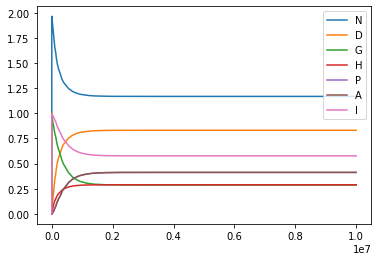

In [25]:
%matplotlib inline
plt.plot(bdf.t,np.array(bdf.y)[:,:7])
plt.legend(['N','D','G','H','P','A','I'],loc='upper right')
plt.show()

In [26]:
ext_masses_org = y0[-5:] * (volcell / volratio)
cell_masses_org = y0[12:17] * (volcell - volmcp)
mcp_masses_org = y0[:7] * volmcp

ext_masses_fin = sol.y[-5:, -1] * (volcell / volratio)
cell_masses_fin = sol.y[12:17, -1] * (volcell - volmcp)
mcp_masses_fin = sol.y[:7, -1] * volmcp

In [27]:
print(ext_masses_org.sum() + cell_masses_org.sum() + mcp_masses_org.sum())
print(ext_masses_fin.sum() + cell_masses_fin.sum() + mcp_masses_fin.sum())
print((sol.y[-5:, -1]).sum() * (volcell / volratio + volmcp + volcell))


1.0472813270006936e-10
1.0470750742935497e-10
1.0470742284932948e-10


## Local Sensitivity Analysis with Sensitivity Equations

In [28]:
def create_param_symbols(*args):
    """
    :param args: list of parameters to analyze using sensitivity analysis
    :return: dictionary of sympy symbols
    """

    params_sens_dict = {arg:sp.symbols(arg) for arg in args}

    return params_sens_dict

In [29]:
def create_state_symbols(nVars,nParams):
    """
    creates a list of sympy symbols for state vectors and derivative of each state vector
    wrt to parameters from create_param_symbols
    :param ngrid: size of grid
    :param nParams: number of parameters
    :return x_sp: list of state variables
    :return sensitivity_sp: list of sensitivity variables
    """

    nSensitivityEqs = nVars * nParams

    #state variables
    x_sp = np.array(sp.symbols('x0:' + str(nVars)))

    #sensitivity variables
    sensitivity_sp = np.array(list(sp.symbols('s0:' + str(nSensitivityEqs))))

    return [x_sp,sensitivity_sp]

In [30]:
def compute_jacs(x_sp,params_sens_dict,integration_params,**kwargs):
    """
    Computes the jacobian of the spatial derivative wrt concentrations (state variables)
    and parameters from create_param_symbols

    :param x_sp: state variables
    :param params_sens_syms: params to compute sensitivity wrt
    :param diffeq_params: dictionary of all paramaters and their values
    :return SDerivSymbolicJacParamsLambFun: jacobian of spatial derivative wrt params
    :return SDerivSymbolicJacConcLambFun: jacobian of spatial derivative wrt concentration
    """

    # check if sensitivity to all params
    if kwargs['diffeq_params'] is None:
        diffeq_params = params_sens_dict
        params_sensitivity_sp = list(params_sens_dict.values())

    else:
        diffeq_params = kwargs['diffeq_params'].copy()
        params_sensitivity_sp = list(params_sens_dict.values())
        for key,value in params_sens_dict.items():
            diffeq_params[key] = value

    SDerivSymbolic = sp.Matrix(SDeriv(0,x_sp,integration_params,diffeq_params))

    # derivative of rhs wrt params
    SDerivSymbolicJacParams = SDerivSymbolic.jacobian(params_sensitivity_sp)
    SDerivSymbolicJacParamsLamb = sp.lambdify((x_sp,params_sensitivity_sp), SDerivSymbolicJacParams,'numpy')
    SDerivSymbolicJacParamsLambFun = lambda t,x,params: SDerivSymbolicJacParamsLamb(x,params)

    # derivative of rhs wrt Conc
    SDerivSymbolicJacConc = SDerivSymbolic.jacobian(x_sp)
    SDerivSymbolicJacConcLamb = sp.lambdify((x_sp,params_sensitivity_sp),SDerivSymbolicJacConc,'numpy')
    SDerivSymbolicJacConcLambFun = lambda t,x,params: SDerivSymbolicJacConcLamb(x,params)

    return [SDerivSymbolicJacParamsLambFun,SDerivSymbolicJacConcLambFun]

In [31]:
def dSens(t,xs,diffeq_params, integration_params,
          SDerivSymbolicJacParamsLambFun, SDerivSymbolicJacConcLambFun):
    """
    Compute RHS of the sensitivity equation

    :param t: time
    :param xs: state variables and sensitivity variables
    :param diffeq_params: dictionary of differential equation parameters
    :param integration_params: dictionary of differential equation parameters
    :param SDerivSymbolicJacParamsLambFun:
    :param SDerivSymbolicJacConcLambFun:
    :return dxs: RHS of the sensitivity system
    """
    # initialization
    nVars = integration_params['nVars']
    x = xs[:nVars]
    s = xs[nVars:]
    dxs = []
    params_sens_dict = integration_params['Sensitivity Params']
    nParams = integration_params['nParams']
    nSensitivityEqs = integration_params['nSensitivityEqs']

    # get rhs of x
    dxs.extend(SDeriv(0, x, integration_params, diffeq_params))
    # get values of params
    param_vals = [diffeq_params[key] for key in params_sens_dict.keys()]
    # compute rhs of sensitivity equations
    SDerivSymbolicJacParamsMat = SDerivSymbolicJacParamsLambFun(t,x,param_vals)
    SDerivSymbolicJacConcMat = SDerivSymbolicJacConcLambFun(t,x,param_vals)
    for i in range(nVars):
        for j in range(nParams):
            dxs.append(np.dot(SDerivSymbolicJacConcMat[i,:], s[range(j,nSensitivityEqs,nParams)])
                       + SDerivSymbolicJacParamsMat[i,j])
    return dxs

def create_jac_sens(x_sp,sensitivity_sp,diffeq_params, integration_params,
                    SDerivSymbolicJacParamsLambFun,SDerivSymbolicJacConcLambFun):
    """
    Computes the jacobian matrix of the dSens
    :param x_sp: symbols of the state variables
    :param sensitivity_sp: symbols of the senstivity equation
    :param diffeq_params: dictionary of the parameter values
    :param integration_params: dictionary of integration parameters
    :param SDerivSymbolicJacParamsLambFun: jacobian of spatial derivative wrt params
    :param SDerivSymbolicJacConcLambFun: jacobian of spatial derivative wrt state variables
    :return dSensSymJacSparseMatLamFun: sparse jacobian of dSens wrt the concentrations
    """

    # create state variables
    allVars = np.concatenate((x_sp,sensitivity_sp))

    #create RHS
    dSensSym = sp.Matrix(dSens(0,allVars,diffeq_params, integration_params,
          SDerivSymbolicJacParamsLambFun, SDerivSymbolicJacConcLambFun))
    dSensSymJac = dSensSym.jacobian(allVars)

    # generate jacobian
    dSensSymJacDenseMatLam = sp.lambdify(allVars,dSensSymJac)
    dSensSymJacSparseMatLamFun = lambda t,xs: sparse.csr_matrix(dSensSymJacDenseMatLam(*xs))

    return dSensSymJacSparseMatLamFun

In [32]:
# get parameters
ngrid = 10
integration_params = initialize_integration_params(ngrid=ngrid)
params = {'KmDhaTH': 0.77,
          'KmDhaTN': 0.03,
          'KiDhaTD': 0.23,
          'KiDhaTP': 7.4,
          'VfDhaT' : 86.2,
          'VfDhaB' : 10.,
          'KmDhaBG' : 0.01,
          'KiDhaBH' : 5.,
          'VfIcdE' : 30.,
          'KmIcdED' : 0.1,
          'KmIcdEI' : 0.02,
          'KiIcdEN' : 3.,
          'KiIcdEA' : 10.,
          'km' : 0.1,
          'kc': 1.,
          'GInit':10,
          'IInit':10,
          'NInit':20,
          'DInit':20}

# create dictionary of integration parameters
params_sens_dict = create_param_symbols('VfDhaT',
                                        'VfDhaB',
                                        'VfIcdE',
                                        'km',
                                        'kc')

# compute non-dimensional scaling
dimscalings = initialize_dim_scaling(**params)

# store info about state variables
n_compounds_cell = 5
nVars = n_compounds_cell * (2 + (integration_params['ngrid'])) + 2
integration_params['nVars'] = nVars

# store info about parameters
nParams = len(params_sens_dict)
integration_params['nParams'] = nParams
integration_params['Sensitivity Params'] = params_sens_dict
nSensitivityEqs = integration_params['nParams']*integration_params['nVars']
integration_params['nSensitivityEqs'] = nSensitivityEqs

# initial conditions -- state variable
n_compounds_cell = 5
y0 = np.zeros((integration_params['ngrid'] + 2) * n_compounds_cell + 2)
y0[-5] = params['GInit']/ dimscalings['G0']  # y0[-5] gives the initial state of the external substrate.
y0[-1] = params['IInit'] / dimscalings['I0']  # y0[-1] gives the initial state of the external substrate.
y0[0] = params['NInit'] / dimscalings['N0']  # y0[5] gives the initial state of the external substrate.
y0[1] = params['DInit'] / dimscalings['D0']  # y0[6] gives the initial state of the external substrate.


# initial conditions -- sensitivity equation
sens0 = np.zeros(nSensitivityEqs)
for i,param in enumerate(params_sens_dict):
    if param in ['GInit', 'IInit', 'NInit', 'DInit']:
        sens0[i:nSensitivityEqs:nParams] = 1/params[param]
xs0 = np.concatenate([y0,sens0])

# setup differential eq
x_sp, sensitivity_sp = create_state_symbols(integration_params['nVars'], integration_params['nParams'])
SDerivSymbolicJacParamsLambFun, SDerivSymbolicJacConcLambFun = compute_jacs(x_sp, params_sens_dict,integration_params, diffeq_params=params)
dSensParams = lambda t,xs: np.array(dSens(t, xs, params, integration_params, SDerivSymbolicJacParamsLambFun,
                                 SDerivSymbolicJacConcLambFun))

#create jacobian of dSensParams
dSensSymJacSparseMatLamFun = create_jac_sens(x_sp, sensitivity_sp, params, integration_params,
                                             SDerivSymbolicJacParamsLambFun, SDerivSymbolicJacConcLambFun)



In [33]:
# solution params
fintime = 1e7
mintime = 1
tol = 1e-10
nsamples = 100
timeorig = np.logspace(np.log10(mintime),np.log10(fintime),nsamples)

In [ ]:
starttime = time.time()
sol = solve_ivp(dSensParams,[0, fintime], xs0, method="BDF", jac = dSensSymJacSparseMatLamFun, t_eval=timeorig,
                atol=1.0e-2, rtol=1.0e-2)
endtime = time.time()
print('code time: ' + str(endtime-starttime))
# plot state variables solution
print(sol.message)

In [37]:
start_time= time.time()
bdf=BDF(dSensParams, xs0, [0,1e7], devrhs = dSensSymJacSparseMatLamFun, dt = .1,
        min_dt=1e-30, max_dt = 5.e6,abstol=100.,order=1)
[status,t,y] = bdf.integrate()
end_time= time.time()
print('time: ' + str(end_time-start_time))

    t     	     dt     	 ||slope||_1 	 time
0.0000e+00 	 1.0000e+00  	 0.0000e+00 	 0.0000e+00
2.6193e-10 	 5.8208e-11  	 1.9491e+05 	 2.1670e+00
2.6193e-10 	 2.9104e-11  	 1.9491e+05 	 2.2030e+00
5.5297e-10 	 5.8208e-11  	 1.9491e+05 	 2.8353e+00
5.5297e-10 	 2.9104e-11  	 1.9491e+05 	 2.8718e+00
8.4401e-10 	 5.8208e-11  	 1.9491e+05 	 3.5084e+00
8.4401e-10 	 2.9104e-11  	 1.9491e+05 	 3.5447e+00
1.1350e-09 	 5.8208e-11  	 1.9491e+05 	 4.1796e+00
1.1350e-09 	 2.9104e-11  	 1.9491e+05 	 4.2156e+00
1.4261e-09 	 5.8208e-11  	 1.9491e+05 	 4.8446e+00
1.4261e-09 	 2.9104e-11  	 1.9491e+05 	 4.8807e+00
1.7171e-09 	 5.8208e-11  	 1.9491e+05 	 5.5130e+00
1.7171e-09 	 2.9104e-11  	 1.9491e+05 	 5.5487e+00
2.0082e-09 	 5.8208e-11  	 1.9491e+05 	 6.1791e+00
2.0082e-09 	 2.9104e-11  	 1.9491e+05 	 6.2157e+00
2.2992e-09 	 5.8208e-11  	 1.9491e+05 	 6.8457e+00
2.2992e-09 	 2.9104e-11  	 1.9491e+05 	 6.8816e+00
2.5902e-09 	 5.8208e-11  	 1.9491e+05 	 7.5134e+00
2.5902e-09 	 2.9104e-11  	 1.9491e+05 

2.1799e-08 	 5.8208e-11  	 1.9491e+05 	 5.4750e+01
2.1799e-08 	 2.9104e-11  	 1.9491e+05 	 5.4785e+01
2.2090e-08 	 5.8208e-11  	 1.9491e+05 	 5.5470e+01
2.2090e-08 	 2.9104e-11  	 1.9491e+05 	 5.5507e+01
2.2381e-08 	 5.8208e-11  	 1.9491e+05 	 5.6201e+01
2.2381e-08 	 2.9104e-11  	 1.9491e+05 	 5.6237e+01
2.2672e-08 	 5.8208e-11  	 1.9491e+05 	 5.6923e+01
2.2672e-08 	 2.9104e-11  	 1.9491e+05 	 5.6978e+01
2.2963e-08 	 5.8208e-11  	 1.9491e+05 	 5.7800e+01
2.2963e-08 	 2.9104e-11  	 1.9491e+05 	 5.7850e+01
    t     	     dt     	 ||slope||_1 	 time
2.3254e-08 	 5.8208e-11  	 1.9491e+05 	 5.8619e+01
    t     	     dt     	 ||slope||_1 	 time
2.3254e-08 	 2.9104e-11  	 1.9491e+05 	 5.8657e+01
2.3545e-08 	 5.8208e-11  	 1.9491e+05 	 5.9587e+01
2.3545e-08 	 2.9104e-11  	 1.9491e+05 	 5.9643e+01
2.3836e-08 	 5.8208e-11  	 1.9491e+05 	 6.0599e+01
2.3836e-08 	 2.9104e-11  	 1.9491e+05 	 6.0636e+01
2.4127e-08 	 5.8208e-11  	 1.9491e+05 	 6.1354e+01
2.4127e-08 	 2.9104e-11  	 1.9491e+05 	 6.139

    t     	     dt     	 ||slope||_1 	 time
4.3627e-08 	 5.8208e-11  	 1.9491e+05 	 1.0898e+02
    t     	     dt     	 ||slope||_1 	 time
4.3627e-08 	 2.9104e-11  	 1.9491e+05 	 1.0902e+02
4.3918e-08 	 5.8208e-11  	 1.9491e+05 	 1.0966e+02
4.3918e-08 	 2.9104e-11  	 1.9491e+05 	 1.0970e+02
4.4209e-08 	 5.8208e-11  	 1.9491e+05 	 1.1034e+02
4.4209e-08 	 2.9104e-11  	 1.9491e+05 	 1.1037e+02
4.4500e-08 	 5.8208e-11  	 1.9491e+05 	 1.1100e+02
4.4500e-08 	 2.9104e-11  	 1.9491e+05 	 1.1104e+02
4.4791e-08 	 5.8208e-11  	 1.9491e+05 	 1.1167e+02
4.4791e-08 	 2.9104e-11  	 1.9491e+05 	 1.1171e+02
4.5082e-08 	 5.8208e-11  	 1.9491e+05 	 1.1235e+02
4.5082e-08 	 2.9104e-11  	 1.9491e+05 	 1.1239e+02
4.5373e-08 	 5.8208e-11  	 1.9491e+05 	 1.1303e+02
4.5373e-08 	 2.9104e-11  	 1.9491e+05 	 1.1307e+02
4.5664e-08 	 5.8208e-11  	 1.9491e+05 	 1.1372e+02
4.5664e-08 	 2.9104e-11  	 1.9491e+05 	 1.1376e+02
4.5955e-08 	 5.8208e-11  	 1.9491e+05 	 1.1440e+02
4.5955e-08 	 2.9104e-11  	 1.9491e+05 	 1.144

6.5163e-08 	 5.8208e-11  	 1.9491e+05 	 1.5862e+02
6.5163e-08 	 2.9104e-11  	 1.9491e+05 	 1.5866e+02
6.5455e-08 	 5.8208e-11  	 1.9491e+05 	 1.5929e+02
6.5455e-08 	 2.9104e-11  	 1.9491e+05 	 1.5933e+02
6.5746e-08 	 5.8208e-11  	 1.9491e+05 	 1.5996e+02
6.5746e-08 	 2.9104e-11  	 1.9491e+05 	 1.6000e+02
6.6037e-08 	 5.8208e-11  	 1.9491e+05 	 1.6063e+02
6.6037e-08 	 2.9104e-11  	 1.9491e+05 	 1.6067e+02
6.6328e-08 	 5.8208e-11  	 1.9491e+05 	 1.6130e+02
6.6328e-08 	 2.9104e-11  	 1.9491e+05 	 1.6133e+02
6.6619e-08 	 5.8208e-11  	 1.9491e+05 	 1.6204e+02
6.6619e-08 	 2.9104e-11  	 1.9491e+05 	 1.6208e+02
    t     	     dt     	 ||slope||_1 	 time
6.6910e-08 	 5.8208e-11  	 1.9491e+05 	 1.6273e+02
    t     	     dt     	 ||slope||_1 	 time
6.6910e-08 	 2.9104e-11  	 1.9491e+05 	 1.6276e+02
6.7201e-08 	 5.8208e-11  	 1.9491e+05 	 1.6343e+02
6.7201e-08 	 2.9104e-11  	 1.9491e+05 	 1.6347e+02
6.7492e-08 	 5.8208e-11  	 1.9491e+05 	 1.6413e+02
6.7492e-08 	 2.9104e-11  	 1.9491e+05 	 1.641

8.6991e-08 	 5.8208e-11  	 1.9491e+05 	 2.0973e+02
8.6991e-08 	 2.9104e-11  	 1.9491e+05 	 2.0977e+02
    t     	     dt     	 ||slope||_1 	 time
8.7282e-08 	 5.8208e-11  	 1.9491e+05 	 2.1040e+02
    t     	     dt     	 ||slope||_1 	 time
8.7282e-08 	 2.9104e-11  	 1.9491e+05 	 2.1044e+02
8.7573e-08 	 5.8208e-11  	 1.9491e+05 	 2.1108e+02
8.7573e-08 	 2.9104e-11  	 1.9491e+05 	 2.1111e+02
8.7864e-08 	 5.8208e-11  	 1.9491e+05 	 2.1174e+02
8.7864e-08 	 2.9104e-11  	 1.9491e+05 	 2.1178e+02
8.8156e-08 	 5.8208e-11  	 1.9491e+05 	 2.1241e+02
8.8156e-08 	 2.9104e-11  	 1.9491e+05 	 2.1245e+02
8.8447e-08 	 5.8208e-11  	 1.9491e+05 	 2.1308e+02
8.8447e-08 	 2.9104e-11  	 1.9491e+05 	 2.1311e+02
8.8738e-08 	 5.8208e-11  	 1.9491e+05 	 2.1375e+02
8.8738e-08 	 2.9104e-11  	 1.9491e+05 	 2.1379e+02
8.9029e-08 	 5.8208e-11  	 1.9491e+05 	 2.1442e+02
8.9029e-08 	 2.9104e-11  	 1.9491e+05 	 2.1446e+02
8.9320e-08 	 5.8208e-11  	 1.9491e+05 	 2.1508e+02
8.9320e-08 	 2.9104e-11  	 1.9491e+05 	 2.151

1.0853e-07 	 5.8208e-11  	 1.9491e+05 	 2.5933e+02
1.0853e-07 	 2.9104e-11  	 1.9491e+05 	 2.5937e+02
1.0882e-07 	 5.8208e-11  	 1.9491e+05 	 2.6000e+02
1.0882e-07 	 2.9104e-11  	 1.9491e+05 	 2.6003e+02
1.0911e-07 	 5.8208e-11  	 1.9491e+05 	 2.6066e+02
1.0911e-07 	 2.9104e-11  	 1.9491e+05 	 2.6070e+02
1.0940e-07 	 5.8208e-11  	 1.9491e+05 	 2.6133e+02
1.0940e-07 	 2.9104e-11  	 1.9491e+05 	 2.6137e+02
1.0969e-07 	 5.8208e-11  	 1.9491e+05 	 2.6200e+02
1.0969e-07 	 2.9104e-11  	 1.9491e+05 	 2.6204e+02
1.0998e-07 	 5.8208e-11  	 1.9491e+05 	 2.6267e+02
1.0998e-07 	 2.9104e-11  	 1.9491e+05 	 2.6271e+02
1.1027e-07 	 5.8208e-11  	 1.9491e+05 	 2.6334e+02
1.1027e-07 	 2.9104e-11  	 1.9491e+05 	 2.6337e+02
    t     	     dt     	 ||slope||_1 	 time
1.1057e-07 	 5.8208e-11  	 1.9491e+05 	 2.6401e+02
    t     	     dt     	 ||slope||_1 	 time
1.1057e-07 	 2.9104e-11  	 1.9491e+05 	 2.6405e+02
1.1086e-07 	 5.8208e-11  	 1.9491e+05 	 2.6468e+02
1.1086e-07 	 2.9104e-11  	 1.9491e+05 	 2.647

## Graphical Local Sensitivity Analysis

In [ ]:
def model_IcdE(KmDhaBG,KiDhaBH,VfDhaB,KmIcdEN,KmIcdEA,KiIcdED,KiIcdEI,VfIcdE,NInit,DInit):
    # state space and time scaling
    G0 = KmDhaBG
    H0 = KmDhaTH
    N0 = KmDhaTN
    P0 = KiDhaTP
    D0 = KiIcdED
    A0 = KmIcdEA
    I0 = KiIcdEI
    t0 = 3*r_mcp/perm_mcp

    y0[-5] = SInit/G0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
    y0[5] = NInit/N0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
    y0[6] = DInit/D0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity

    #non-dimensional parameters
    alpha1 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/G0
    alpha2 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/H0
    alpha3 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/H0
    alpha4 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/N0
    alpha5 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(N0*KmIcdEN)
    alpha6 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/P0
    alpha7 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/D0
    alpha8 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(D0*KmIcdEN)
    alpha9 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(I0*KmIcdEN)
    alpha10 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(A0*KmIcdEN)

    beta1 = KmDhaTH/KiDhaBH
    beta2 = KiIcdED/KiDhaTD
    beta3 = KmDhaTN/KmIcdEN

    SDev = rhs(KmDhaBG,KiDhaBH,VfDhaB,KmIcdEN,KmIcdEA,KiIcdED,KiIcdEI,VfIcdE)

    sol = odeint(SDev, y0, timeorig)
    
    return sol[-1,-5]


In [ ]:
problem = {
    'num_vars': 10,
    'names': ['KmDhaBG','KiDhaBH','VfDhaB','KmIcdEN','KmIcdEA','KiIcdED','KiIcdEI','VfIcdE','NInit','DInit'],
    'bounds': np.repeat([[5,10]], 10,axis=0)
}



In [ ]:
param_values = saltelli.sample(problem, 2)

In [ ]:
param_values.shape[0]

In [ ]:
Y = np.zeros([param_values.shape[0]])

for i, X in enumerate(param_values):
    Y[i] = model_IcdE(*X)

In [ ]:
sobol.analyze(problem, Y)

In [ ]:
# manual local senstivity analysis

test_vals = [1.0,10.0]

for KmDhaBG in test_vals: #Km for G in G <--> H
    for KiDhaBH in test_vals: #Km for H in G <--> H
        for VfDhaB in test_vals: #Vf for G <--> H
            for KmIcdEN in test_vals: #Km for N in N + A <--> I + D
                for KmIcdEA in test_vals: #Km for A in N + A <--> I + D
                    for KiIcdED in test_vals: #Ki for D in N + A <--> I + D
                        for KiIcdEI in test_vals: #Ki for I in N + A <--> I + D
                            for VfIcdE in test_vals: #Vf for N + A <--> I + D


                                # state space and time scaling
                                G0 = KmDhaBG
                                H0 = KmDhaTH
                                N0 = KmDhaTN
                                P0 = KiDhaTP
                                D0 = KiIcdED
                                A0 = KmIcdEA
                                I0 = KiIcdEI
                                t0 = 3*r_mcp/perm_mcp

                                y0[-5] = SInit/G0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
                                y0[5] = NInit/N0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
                                y0[6] = DInit/D0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity

                                #non-dimensional parameters
                                alpha1 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/G0
                                alpha2 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/H0
                                alpha3 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/H0
                                alpha4 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/N0
                                alpha5 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(N0*KmIcdEN)
                                alpha6 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/P0
                                alpha7 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/D0
                                alpha8 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(D0*KmIcdEN)
                                alpha9 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(I0*KmIcdEN)
                                alpha10 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(A0*KmIcdEN)

                                beta1 = KmDhaTH/KiDhaBH
                                beta2 = KiIcdED/KiDhaTD
                                beta3 = KmDhaTN/KmIcdEN
                                
                                #spatial derivative
                                SDev = rhs(KmDhaBG,KiDhaBH,VfDhaB,KmIcdEN,KmIcdEA,KiIcdED,KiIcdEI,VfIcdE)
                                
                                #solution
                                sol = odeint(SDev, y0, timeorig)
                                
                                #plot solution
                                plt.plot(timeorig,sol[:,-5:])
                                plt.show()
